# Visualize results of UBOT on synthetic data

In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import torch
from unot.plotting.setup import setup_plt
from unot.models.nubot import compute_weights_unbs
from unot.training.train_nubot import plot_weights

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from ml_collections import ConfigDict
from unot.data.toy import load_toy_data
from unot.data.utils import cast_loader_to_iterator

import ot

palette_big = [
        "#1A254B",
        "#114083",
        "#386cb5",
        "#A7BED3",
        "#c3cdd6",
        "#cccccc",
        "#d1bebe",
        "#e08285",
        "#F2545B",
        "#A4243B",
        "#8c0e25",
    ]
setup_plt()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/frederike/miniconda3/envs/u/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load data

with open("../config/models/nubot_v1.yaml") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
config = ConfigDict(config)
# config file of synthetic dataset
setup = "toy-triangle-unbalanced-1"
with open(f"../config/data/{setup}.yaml") as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)
config.update(data_config)
config.data.loader.batch_size = 400
np.random.seed(0)
loader, model_kwargs = load_toy_data(config, include_model_kwargs=True)
data = cast_loader_to_iterator(loader, cycle_all=True)
input_dim = model_kwargs.pop("input_dim", 2)
x = np.array(next(data.train.source))
y = np.array(next(data.train.target))

a = np.ones(len(x)) / len(x)
b = np.ones(len(y)) / len(y)
M = ot.dist(x, y)
M /= M.max()

len(x), len(y)

Batch_sizes:  {'train.source': 400, 'train.target': 400, 'test.source': 400, 'test.target': 400}


(400, 400)

In [5]:
# function to plot results

sns.set_context(context="talk", font_scale=1.3)
plt.rcParams["font.family"] = "serif"#"Times New Roman"

def plot_row(x,y,gamma, title=""):

    fig, axes = plt.subplots(
            nrows=1, ncols=3, sharex=False, sharey=False, figsize=(10, 3), constrained_layout=True
        )

    def show_avg_w(lower, left, right):
        plt.text(x=1.8, y=-5.5, s=round(lower,2), color="grey")
        plt.text(x=-5, y=1.5, s=round(left,2), color="grey")
        plt.text(x=4, y=1.5, s=round(right,2), color="grey")

    def show_avg_wy(lower, left, right):
        plt.text(x=1.8, y=-8.5, s=round(lower,2), color="grey")
        plt.text(x=-5, y=7, s=round(left,2), color="grey")
        plt.text(x=3, y=7, s=round(right,2), color="grey")
    
    def compute_avg_w(x, w):
        # lower 
        mask = x[:,1] < 0
        nlower = mask.sum()
        lower = w[mask].mean()

        # left
        mask = (x[:,1] > 0) & (x[:,0] < 0)
        nleft = mask.sum()
        left = w[mask].mean()

        # right
        mask = (x[:,1] > 0) & (x[:,0] > 0)
        nright = mask.sum()
        right = w[mask].mean()

        assert nlower+nleft+nright == len(x)
        assert np.isclose(nlower*lower.sum()+nleft*left.sum()+nright*right.sum(),w.sum())

        return lower, left, right

    for i in range(axes.shape[0]):
        axes[i].spines["top"].set_visible(False)
        axes[i].spines["right"].set_visible(False)

    # COUPLING

    s=4
    alpha=0.6
    plt.sca(axes[0])
    plt.scatter(x[:,0], x[:,1], color=palette_big[-3], alpha=alpha,label="source", s=s)
    plt.scatter(y[:,0], y[:,1], color=palette_big[1], alpha=alpha,label="target", s=s)
    plt.title("Coupling")

    P = gamma
    if P.sum() > 0:
        P = P / P.max()
    n = int(0.3*len(x))
    m = int(0.3*len(y))
    for i in range(n):
        for j in range(m):
            if P[i, j] > 0:
                dx = y[j, 0] - x[i, 0]
                dy = y[j, 1] - x[i, 1]
                plt.arrow(x[i, 0], x[i, 1], dx, dy, alpha=0.03*P[i, j], color="grey", width=0.0001) 

    plt.tick_params(
                axis="both",  # changes apply to the x-axis
                which="both",  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False,
                left=False,
                right=False,
                labelleft=False,
            )

    # WEIGHTS

    plt.sca(axes[1])

    wx = gamma.sum(axis=1) * len(x)
    wy = gamma.sum(axis=0) * len(y)

    plt.scatter(x[:,0], x[:,1], c=wx, alpha=alpha,label="source", s=s)
    plt.clim(0,2)
    #plt.scatter(y[:,0], y[:,1], c=wy, alpha=alpha,label="predicted", s=s)

    show_avg_w(*compute_avg_w(x,wx))
    # show_avg_wy(*compute_avg_w(y,wy))

    # plt.colorbar()
    # plt.set_cmap(cmap="BBR_r")
    # plt.clim(0,2)


    plt.title("Weights")

    plt.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
        left=False,
        right=False,
        labelleft=False,
    )
    # NORMALIZED WEIGHTS

    plt.sca(axes[2])

    wx = gamma.sum(axis=1) * len(x) / gamma.sum()
    wy = gamma.sum(axis=0) * len(y) / gamma.sum()

    plt.scatter(x[:,0], x[:,1], c=wx, alpha=alpha, label="source", s=s)
    plt.colorbar()
    plt.set_cmap(cmap="BBR_r")
    plt.clim(0,2)

    # plt.scatter(y[:,0], y[:,1], c=wy, alpha=alpha, label="predicted", s=s)
    # plt.clim(0,2)

    show_avg_w(*compute_avg_w(x,wx))
    #show_avg_wy(*compute_avg_w(y,wy))


    plt.title("Norm. Weights")

    plt.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
        left=False,
        right=False,
        labelleft=False,
    )
    #plt.savefig(f"toy_{setup}_{model}.pdf", format="pdf", bbox_inches="tight")


reg=0.005, reg_m=0.01, mass=2.630899965456923
reg=0.005, reg_m=0.05, mass=1.1639391962395391
reg=0.005, reg_m=0.1, mass=1.0568474826766658
reg=0.005, reg_m=1, mass=0.8684689887563741
reg=0.005, reg_m=10, mass=0.9911883085700709
reg=0.05, reg_m=0.01, mass=1433.0424293277138
reg=0.05, reg_m=0.05, mass=28.760107278963535
reg=0.05, reg_m=0.1, mass=7.373904326355036
reg=0.05, reg_m=1, mass=1.2463192172224298
reg=0.05, reg_m=10, mass=1.0213196658947483


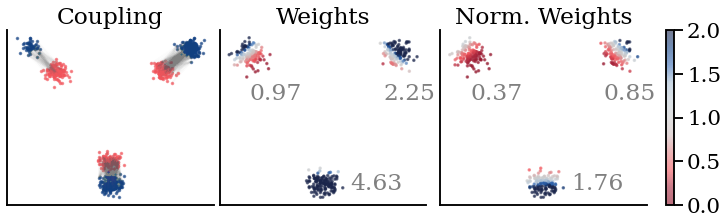

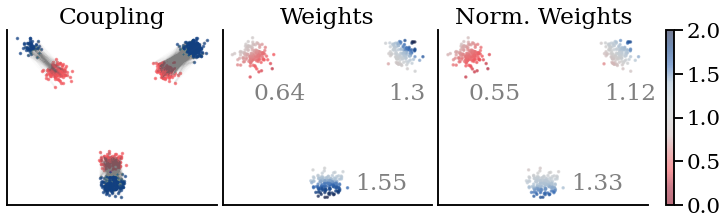

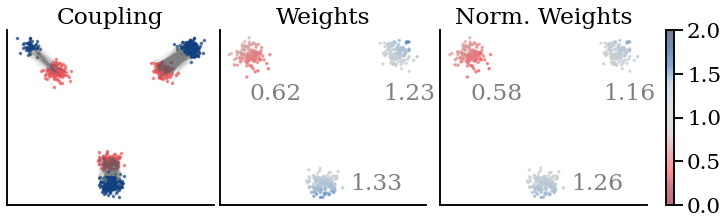

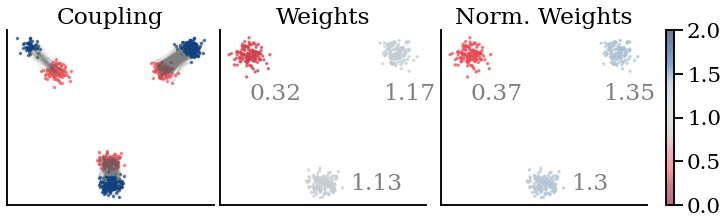

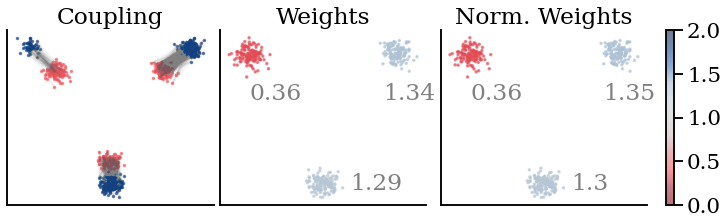

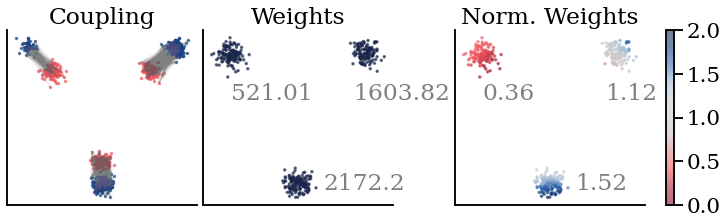

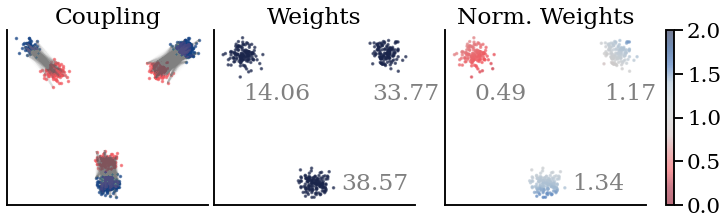

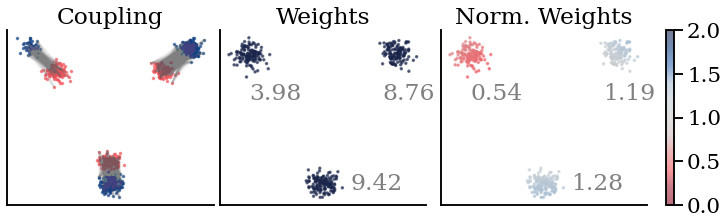

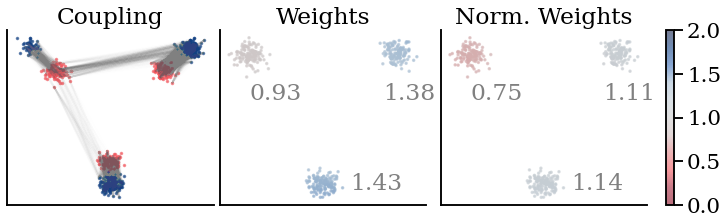

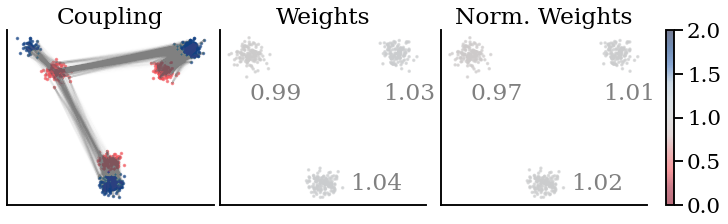

In [6]:
regs = [0.005, 0.05]
reg_ms = [0.01, 0.05, 0.1, 1, 10] 
i = 0
for reg in regs:
    for reg_m in reg_ms:
        a = np.ones(len(x)) / len(x)
        b = np.ones(len(y)) / len(y)
        M = ot.dist(x, y)
        M /= M.max()
        gamma = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m, method="sinkhorn_stabilized")
        tm = gamma.sum()
        title=f"reg={reg}, reg_m={reg_m}, mass={tm}"
        print(title)
        plot_row(x,y,gamma, title=title)
        #plt.savefig(f"toy_{setup}_{i}.pdf", format="pdf", bbox_inches="tight")
        i+=1

In [98]:
M = ot.dist(x, y)
M /= M.max()
gamma = ot.unbalanced.sinkhorn_unbalanced(a, b, M, 0.1, 0.001)

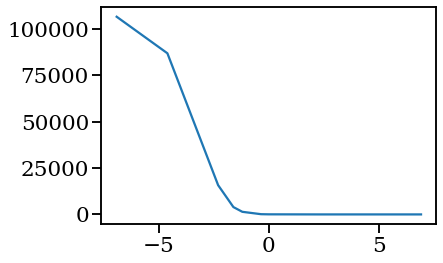

In [101]:
masses = []
reg = 1
reg_ms=[0.001, 0.01, 0.1, 0.2, 0.3, 0.7 ,1, 10, 100, 1000]
#reg_ms=[1, 10, 100, 1000]
for reg_m in reg_ms:
    M = ot.dist(x, y)
    M /= M.max()
    gamma = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m)
    masses.append(gamma.sum())
plt.plot(np.log(reg_ms), masses)